In [1]:
import pandas as pd
import re
from textblob import TextBlob
import matplotlib.pyplot as plt

### Cargamos en un df el reviews_inicial.parquet

In [2]:
df_reviews=pd.read_parquet('processed_data/reviews_inicial.parquet')
df_reviews.head()

,user_id,user_url,funny,posted,last_edited,item_id,helpful,recommend,review
0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,,"Posted November 5, 2011.",,1250,No ratings yet,True,Simple yet with great replayability. In my opi...
1,76561197970982479,http://steamcommunity.com/profiles/76561197970...,,"Posted July 15, 2011.",,22200,No ratings yet,True,It's unique and worth a playthrough.
2,76561197970982479,http://steamcommunity.com/profiles/76561197970...,,"Posted April 21, 2011.",,43110,No ratings yet,True,Great atmosphere. The gunplay can be a bit chu...
3,js41637,http://steamcommunity.com/id/js41637,,"Posted June 24, 2014.",,251610,15 of 20 people (75%) found this review helpful,True,I know what you think when you see this title ...
4,js41637,http://steamcommunity.com/id/js41637,,"Posted September 8, 2013.",,227300,0 of 1 people (0%) found this review helpful,True,For a simple (it's actually not all that simpl...


### Se verifica que no haya valores nulos

In [3]:
df_reviews.isnull().sum()

user_id         0
user_url        0
funny          28
posted         28
last_edited    28
item_id        28
helpful        28
recommend      28
review         28
dtype: int64

### Se eliminan los registros que no tienen reviews sobre ningun juego

In [4]:
df_reviews = df_reviews.dropna(subset=['review'])

### #Se verifican filas duplicadas en todo el DataFrame

In [5]:
duplicadas = df_reviews.duplicated()

### Aplicamos la mascara booleana para mostrar los duplicados

In [6]:
df_reviews[duplicadas]

,user_id,user_url,funny,posted,last_edited,item_id,helpful,recommend,review
1114,bokkkbokkk,http://steamcommunity.com/id/bokkkbokkk,,"Posted September 24, 2015.",,346110,1 of 1 people (100%) found this review helpful,True,yep
2894,ImSeriouss,http://steamcommunity.com/id/ImSeriouss,,"Posted January 10, 2014.",,218620,1 of 3 people (33%) found this review helpful,True,"Good graphics, fun heists! A bit laggy"
2895,ImSeriouss,http://steamcommunity.com/id/ImSeriouss,,"Posted January 10, 2014.",,105600,0 of 2 people (0%) found this review helpful,True,So fun! DEFINITELY NOT RIP OFF OF MINECRAFT! e...
2896,ImSeriouss,http://steamcommunity.com/id/ImSeriouss,,"Posted December 17, 2014.",,570,No ratings yet,True,bobo pinoy
2897,ImSeriouss,http://steamcommunity.com/id/ImSeriouss,,"Posted January 13, 2014.",,211820,No ratings yet,True,If you want to play this game.. expect glithes...
...,...,...,...,...,...,...,...,...,...
44456,76561198092022514,http://steamcommunity.com/profiles/76561198092...,,Posted July 3.,,422400,No ratings yet,True,Muy entretenido y una coleccion de armas prome...
44457,76561198092022514,http://steamcommunity.com/profiles/76561198092...,,Posted June 1.,,218620,No ratings yet,True,"Tiene una jugabilidad y tematica muy buena :D,..."
44458,76561198092022514,http://steamcommunity.com/profiles/76561198092...,,"Posted August 17, 2014.",,261820,No ratings yet,True,"Buen juego, no importa el desarrrollo que tien..."
44459,76561198092022514,http://steamcommunity.com/profiles/76561198092...,,"Posted February 17, 2014.",,224260,No ratings yet,True,exelente aporte :DÂ¡Â¡Â¡ es una buen mod basad...


### #Se eliminan las filas duplicadas

In [7]:
df_reviews.drop_duplicates(inplace=True)

### Se realizan procesos de transformacion para la columna posted, normalizando y extrayendo la informacion util

In [8]:
# Se extrae el año del campo 'posted' (se sabe que los registros que solo contienen dia y mes, pero no año, 
# corresponden al año en curso en que se posteo el review.)
# Como el mayor año que se observa es 2015, asumimos que los reviws sin año corresponden a 2016

#Se crea una expresion regular para extraer el año de la cadena de texto
is_year = re.compile(r'(\d{4})')

### Funcion extract_year

In [9]:
def extract_year(posted):
    match = is_year.search(posted)
    if match:
        return int(match.group(1))
    else:
        #Si no se encuentra el año, se asume 2016
        return 2016


### #Se crea una nueva columna con el año de cada review y se elimina la columna posted

In [10]:
df_reviews['posted_year'] = df_reviews['posted'].apply(extract_year)

In [11]:
df_reviews.drop(columns='posted', inplace=True)

### Analisis de sentimiento sobre la columna reviews utilizando la libreria TextBlob de NLP

#### #Se crea una función para realizar análisis de sentimiento y clasificación utilizando textblob

In [12]:
def classify_sentiment(review):
    analysis = TextBlob(str(review))
    #El método sentiment.polarity devuelve un valor entre -1 y 1
    polarity = analysis.sentiment.polarity

    #Se establecen umbrales para clasificar en 0, 1 o 2. Luego de algunas pruebas se consideran apropiados los umbrales -0,1 y 0,1
    if polarity < -0.1:
        return 0  # Negativo
    elif polarity > 0.1:
        return 2  # Positivo
    else:
        return 1  # Neutral


### #Se aplica la función de análisis de sentimiento y a la columna 'review'

In [13]:
df_reviews['sentiment_analysis'] = df_reviews['review'].apply(classify_sentiment)

###  Graficos para mostrar mejor el analisis de sentimiento y las recomendaciones

### #Se muestra un grafico de barras sobre sentiment_analysis

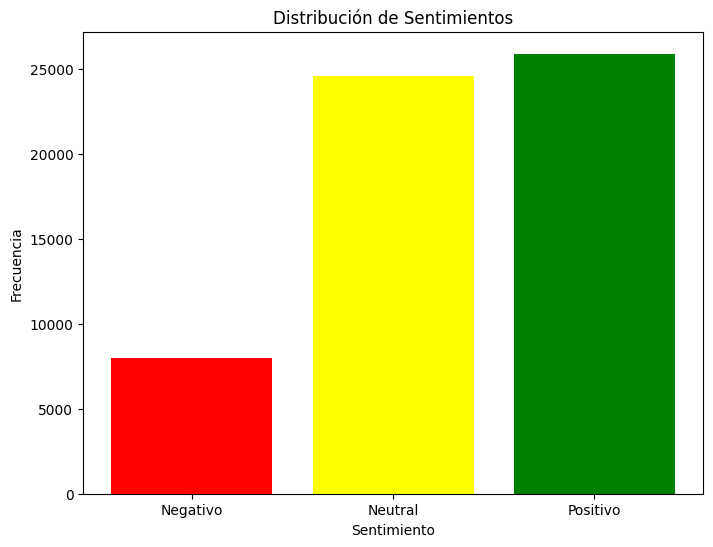

In [20]:
sentiment_count = df_reviews['sentiment_analysis'].value_counts()

plt.figure(figsize=(8, 6))
plt.bar(sentiment_count.index, sentiment_count.values, color=['green', 'yellow', 'red'])
# Agregar etiquetas al eje x
plt.xticks(sentiment_count.index, ['Positivo' , 'Neutral', 'Negativo'])

plt.title('Distribución de Sentimientos')
plt.xlabel('Sentimiento')
plt.ylabel('Frecuencia')

plt.show()

### Recomendaciones

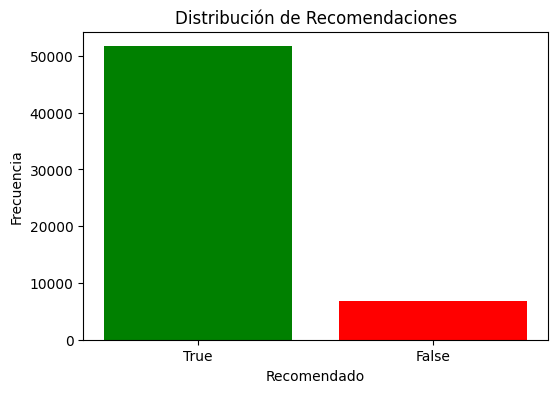

In [21]:
#Se muestra un grafico de barras sobre recommend
recommend_count = df_reviews['recommend'].value_counts()

plt.figure(figsize=(6, 4))
plt.bar(recommend_count.index.astype(str), recommend_count.values, color=['green', 'red'])

plt.title('Distribución de Recomendaciones')
plt.xlabel('Recomendado')
plt.ylabel('Frecuencia')

plt.show()

### #Se muestra un grafico de barras apiladas sobre sentiment_count y recommend

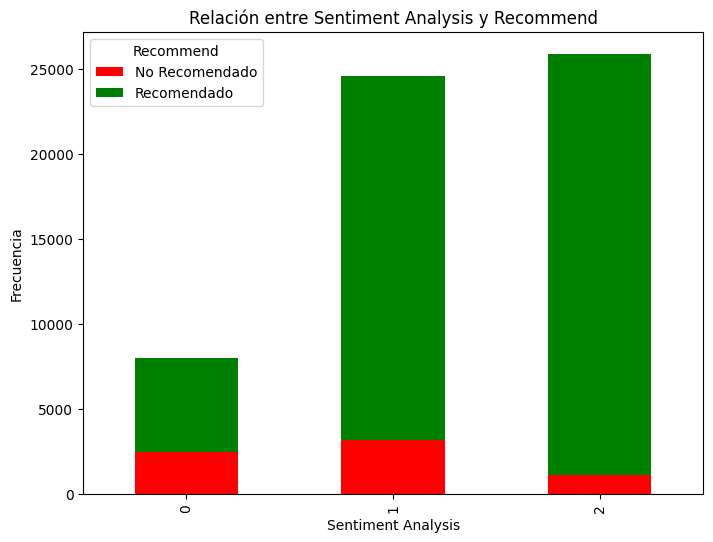

In [22]:
cross_count = pd.crosstab(df_reviews['sentiment_analysis'], df_reviews['recommend'])

cross_count.plot(kind='bar', stacked=True, color=['red', 'green'], figsize=(8, 6))

plt.title('Relación entre Sentiment Analysis y Recommend')
plt.xlabel('Sentiment Analysis')
plt.ylabel('Frecuencia')
plt.legend(title='Recommend', labels=['No Recomendado', 'Recomendado'])

plt.show()

### #Se eliminan columnas que no usaremos

In [23]:
df_reviews.drop(columns='review',inplace=True)

In [24]:
df_reviews.drop(columns=['user_url','funny','last_edited','helpful'],inplace=True)

### Guardamos reviews.parquet

In [25]:
df_reviews.to_parquet('processed_data/reviews.parquet',index=False)